##  Step 1: Create a 1-million–row stratified sample from the full dataset

**Why this step?**  
The full Criteo uplift dataset has ~13 million rows, which is too large to train models efficiently.  
To reduce computation while keeping the dataset representative, we create a **stratified sample**.

**What this code does:**

1. **Loads** the full 13M dataset.  
2. **Decides** the target sample size = 1,000,000 rows.  
3. **Computes** the sampling fraction (about 7–8%).  
4. **Stratifies** based on both `treatment` and `conversion`  
   - ensures the sampled dataset has the same proportions of  
     - treated vs control  
     - converted vs not converted  
5. **Saves** the new 1M-row dataset for all future modeling steps.

This results in a smaller dataset that still represents the original distribution.


In [34]:
import pandas as pd

# 1. Load full dataset (13 million)
df = pd.read_csv("criteo-uplift-v2.1.csv")   # replace name

print("Full dataset size:", len(df))

# 2. Target sample size
target_size = 1_000_000

# 3. Fraction to sample
fraction = target_size / len(df)
print("Sampling fraction:", fraction)

# 4. Stratified sampling using treatment and conversion
df_small = df.groupby(['treatment', 'conversion'], group_keys=False).apply(
    lambda x: x.sample(frac=fraction, random_state=42)
)

print("Sampled size:", len(df_small))

# 5. Save the smaller dataset
df_small.to_csv("sampled_1M.csv", index=False)
print("Saved sampled_1M.csv")


Full dataset size: 13979592
Sampling fraction: 0.07153284587990837


C:\Users\raipr\AppData\Local\Temp\ipykernel_35724\2865659192.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_small = df.groupby(['treatment', 'conversion'], group_keys=False).apply(


Sampled size: 1000000
Saved sampled_1M.csv


##  Step 2: Stratified Train–Test Split (Ensures Balanced Groups)

**Goal:**  
Split the 1M sampled dataset into Train (80%) and Test (20%) **while keeping the proportions of all 4 groups the same**:
- Treated + Visited  
- Treated + Not Visited  
- Control + Visited  
- Control + Not Visited  

**How this works:**
1. We create a new column `stratify_col` combining `treatment` and `visit`  
   → forms 4 balanced groups like `0_0`, `0_1`, `1_0`, `1_1`
2. We use `train_test_split(... stratify=stratify_col)`  
   → ensures train and test have the same distribution of these groups
3. We construct a final `train` dataframe containing:
   - feature columns  
   - treatment label  
   - visit outcome  

**Why this is important:**  
Random splitting can distort class balance.  
Stratified splitting preserves real-world proportions — critical for uplift modeling.


##  Step 3: Quick Sanity Check (View Columns & First Few Rows)

**Purpose:**  
Before moving ahead, we quickly inspect the sampled 1M-row dataset to ensure everything is correct.

**What this cell does:**
- Prints all column names using `df_small.columns`  
- Shows the first 5 rows using `df_small.head()`

**Why this is useful:**
- Confirms that important columns (`treatment`, `visit`, features like `f0..f11`) exist  
- Confirms sampling didn’t remove or damage any columns  
- Lets us visually verify that the data looks clean before training models


In [35]:
print(df_small.columns)
df_small.head()

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'treatment', 'conversion', 'visit', 'exposure'],
      dtype='object')


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
12605436,21.540788,10.059654,8.214383,4.679882,10.280525,4.115453,-4.595460,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0
8298191,16.817444,10.059654,8.727821,3.907662,10.280525,4.115453,-5.987667,4.833815,3.863287,13.190056,5.300375,-0.168679,0,0,0,0
6309259,13.882037,10.059654,8.214383,3.907662,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0
5962129,22.992071,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0
6043432,22.390426,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0


##  Step 4: Check Treatment & Outcome Distributions (Sanity Check)

**Purpose:**  
Verify that the sampled 1M dataset still has the correct proportions of:
- Treated vs Control users  
- Converted vs Not Converted users  
- Visit behavior across treatment groups  

**What this cell prints:**

1. **Treatment Distribution**  
   - Confirms the treatment ratio (Criteo dataset is highly imbalanced ≈ 85% treated).  
   - Ensures sampling kept the same ratio.

2. **Conversion Distribution**  
   - Shows how many users converted vs not.  
   - Checks that conversion remains a rare event.

3. **Conversion Rate by Treatment**  
   - Helps validate uplift signal:  
     *Do treated users convert more than control users?*

4. **Visit Rate by Treatment**  
   - Similar check but for the “visit” outcome.

**Why this matters:**  
If these distributions look wrong, your sampling corrupted the dataset.  
If they look correct, you're safe to proceed to modeling.


In [36]:
print("===== Treatment Distribution =====")
print(df_small['treatment'].value_counts(normalize=True))
print()

print("===== Conversion Distribution =====")
print(df_small['conversion'].value_counts(normalize=True))
print()

print("===== Conversion Rate by Treatment =====")
print(df_small.groupby('treatment')['conversion'].mean())
print()

print("===== Visit Rate by Treatment =====")
print(df_small.groupby('treatment')['visit'].mean())
print()


===== Treatment Distribution =====
treatment
1    0.85
0    0.15
Name: proportion, dtype: float64

===== Conversion Distribution =====
conversion
0    0.997083
1    0.002917
Name: proportion, dtype: float64

===== Conversion Rate by Treatment =====
treatment
0    0.001940
1    0.003089
Name: conversion, dtype: float64

===== Visit Rate by Treatment =====
treatment
0    0.038007
1    0.048631
Name: visit, dtype: float64



##  Step 5: Joint Distribution of Treatment × Conversion

**Purpose:**  
Check the **combined proportions** of the four key customer groups:
- Control + No Conversion  
- Control + Conversion  
- Treated + No Conversion  
- Treated + Conversion  

**What this cell computes:**  
`df_small.groupby(['treatment', 'conversion']).size() / len(df_small)`

This shows what fraction of the sampled dataset lies in each of the 4 categories.

**Why this is important:**  
Uplift modeling relies on having a healthy mix of treatment and conversion outcomes.  
If any of these groups are missing or extremely small, uplift estimation becomes unreliable.

This check confirms that **stratified sampling preserved the balance across these groups**.


In [37]:
df_small.groupby(['treatment', 'conversion']).size().apply(lambda x: x / len(df_small))


treatment  conversion
0          0             0.149709
           1             0.000291
1          0             0.847374
           1             0.002626
dtype: float64

##  Step 6: Distribution of All Four Treatment–Conversion Combinations

**Purpose:**  
Verify how the sampled dataset is distributed across the four combinations of treatment and conversion:

- Treated + Converted  
- Treated + Not Converted  
- Control + Converted  
- Control + Not Converted  

**What this cell does:**  


In [38]:
df_small.groupby(['treatment', 'conversion']).size() / len(df_small)


treatment  conversion
0          0             0.149709
           1             0.000291
1          0             0.847374
           1             0.002626
dtype: float64

## Select outcome, treatment, and feature columns

**Purpose:** Define the target outcome and treatment columns and automatically select the feature columns.

**Details:**
- `OUTCOME_COL` chooses which label we will predict (`'visit'` or `'conversion'`).
- `TREATMENT_COL` indicates the column that marks whether a user received the promotion (`'treatment'`).
- `FEATURE_COLS` automatically gathers all columns named like `f0, f1, ..., f11`.

**Why:** Centralising these choices avoids errors in downstream cells and makes it easy to change the target or treatment variable later.

**Note:** The sampled dataset file created earlier is saved as `sampled_1M.csv` (local path: `/mnt/data/sampled_1M.csv`) if you need to reference or reload it.


In [39]:
# Choose your outcome and treatment
OUTCOME_COL = 'visit'        # or 'conversion'
TREATMENT_COL = 'treatment'  # later you can try 'exposure'

FEATURE_COLS = [c for c in df_small.columns
                if c.startswith('f') and c[1:].isdigit()]  # f0..f11

# Just to be extra sure:
print(FEATURE_COLS, OUTCOME_COL, TREATMENT_COL)


['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11'] visit treatment


## Step 7: Check Missing Values in Feature Columns

**Purpose:**  
Before training models, we need to confirm that none of the feature columns (`f0`…`f11`) contain missing values.

**What the code does:**
- Looks at only the feature columns.
- Computes the **fraction of missing values** in each column.
- Sorts them from smallest to largest.
- Displays the results for quick inspection.

**Why this matters:**  
Models like Random Forest or Logistic Regression can break or perform poorly if features contain missing values.  
This quick check ensures your 1M sampled dataset is clean before proceeding.


In [40]:
df_small[FEATURE_COLS].isna().mean().sort_values().head(12)


f0     0.0
f1     0.0
f2     0.0
f3     0.0
f4     0.0
f5     0.0
f6     0.0
f7     0.0
f8     0.0
f9     0.0
f10    0.0
f11    0.0
dtype: float64

## Step 8: Check for Infinite Values in Features

**Purpose:**  
Ensure none of the feature columns contain infinite values (`+inf` or `-inf`), which can break model training.

**What the code does:**
- Uses `np.isinf()` to detect infinite values in the feature matrix.
- `.any()` returns `True` if at least one infinite value exists.

**Why important:**  
Infinite values can appear from faulty preprocessing or data errors.  
Most machine learning models cannot handle them and will fail or give wrong results.

**Expected output:**  
`False` → your dataset is clean.  


In [41]:
import numpy as np
np.isinf(df_small[FEATURE_COLS]).any()


f0     False
f1     False
f2     False
f3     False
f4     False
f5     False
f6     False
f7     False
f8     False
f9     False
f10    False
f11    False
dtype: bool

In [42]:
df_small[FEATURE_COLS].describe().T


,count,mean,std,min,25%,50%,75%,max
f0,1000000.0,19.627851,5.376253,12.616365,12.616365,21.927979,24.456290,26.745255
f1,1000000.0,10.069883,0.104334,10.059654,10.059654,10.059654,10.059654,15.098192
f2,1000000.0,8.446805,0.299474,8.214383,8.214383,8.214383,8.724827,9.051962
f3,1000000.0,4.180464,1.334050,-7.700578,4.679882,4.679882,4.679882,4.679882
f4,1000000.0,10.338742,0.342622,10.280525,10.280525,10.280525,10.280525,20.306683
f5,1000000.0,4.028459,0.430084,-7.191826,4.115453,4.115453,4.115453,4.115453
f6,1000000.0,-4.153334,4.572006,-30.159875,-6.699321,-2.411115,0.294443,0.294443
f7,1000000.0,5.103054,1.208861,4.833815,4.833815,4.833815,4.833815,11.998328
f8,1000000.0,3.933628,0.056605,3.643174,3.910792,3.971858,3.971858,3.971858
f9,1000000.0,16.021419,7.010788,13.190056,13.190056,13.190056,13.190056,65.623281


##  Step 10: Feature Summary Statistics (Describe Table)

**Purpose:**  
View key descriptive statistics for each feature (`f0`…`f11`) to ensure the data looks normal and consistent before modeling.

**What this cell shows for every feature:**
- `count` – number of valid entries  
- `mean` – average value  
- `std` – spread/variability  
- `min`, `max` – smallest and largest values  
- `25%`, `50%`, `75%` – quartile values  

**Why this matters:**  
This step helps detect:
- unusual value ranges,  
- outliers,  
- incorrect data types,  
- or any signs of corrupted sampling.

If all features show stable, reasonable ranges, you can safely continue to modeling.


## Step 10: Feature Correlation Heatmap

**Purpose:**  
Visualize how strongly each feature (`f0`…`f11`) is related to the others in the training dataset.

**What this code does:**
- Computes the correlation matrix for all feature columns.
- Creates a colorful heatmap using `seaborn.heatmap()`.
- Dark red/blue areas show strong positive/negative correlations.

**Why this is useful:**  
- Highly correlated features may carry duplicate information.  
- Understanding feature relationships helps during model selection and debugging.  
- Even though Random Forest handles correlated features better than linear models,  
  it’s still valuable to inspect overall structure.

**Tip:**  
Set `annot=True` if you want to see exact correlation numbers on the heatmap.


## Step 11: Full Preprocessing Pipeline for Uplift Modeling

This function performs **all preprocessing steps** needed before uplift modeling.  
It takes raw data → cleans it → splits it → transforms it safely → and returns
final Train / Validation / Test sets.

###  What this function does:

### **1. Basic Cleaning**
- Normalizes column names  
- Drops duplicate rows  
- Ensures treatment and outcome are valid 0/1 values  

### **2. Feature Selection**
- Automatically detects numeric feature columns  
- Removes treatment and outcome from the feature list  

### **3. Create “strata” column**
Creates 4 strata groups:
- Treated + Outcome  
- Treated + No Outcome  
- Control + Outcome  
- Control + No Outcome  

Used to ensure balanced splits.

### **4. Stratified Train/Val/Test Splits**
- 80% train/validation  
- 20% test  
- Train further split into train (80%) and validation (20%)  
- All splits use the strata column to preserve treatment/outcome balance  

### **5. Preprocessing (trained on train only)**
- **Low-variance feature removal**  
- **Outlier clipping** using 1st–99th percentile  
- **Log transform** on highly skewed features  
- **Standard Scaling** (fit on train, applied to all splits)  

### **6. Treatment Interaction Features**
For each feature `f`, creates `f_x_treat = f * treatment`.

### **7. Returns**
- `X_train, y_train`  
- `X_val, y_val`  
- `X_test, y_test`  
- Preprocessing metadata:  
  - low-variance columns removed  
  - log columns  
  - clipping thresholds  
  - fitted scaler  

This pipeline ensures **no data leakage**, consistent scaling, outlier robustness,
and uplift-friendly feature engineering.


In [43]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


def preprocess_uplift(df, treatment_col='treatment', outcome_col='conversion'):

    df = df.copy()

    # ---------------------------------------------------------
    # 1. BASIC CLEANING (SAFE BEFORE SPLIT)
    # ---------------------------------------------------------
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    df.drop_duplicates(inplace=True)

    df[treatment_col] = df[treatment_col].astype(int)
    df[outcome_col] = df[outcome_col].astype(int)

    # Keep only 0/1 rows
    df = df[df[treatment_col].isin([0, 1])]
    df = df[df[outcome_col].isin([0, 1])]

    # ---------------------------------------------------------
    # 2. IDENTIFY FEATURE COLUMNS
    # ---------------------------------------------------------
    feature_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    feature_cols = [c for c in feature_cols if c not in [treatment_col, outcome_col]]

    # ---------------------------------------------------------
    # 3. CREATE STRATA FOR UPLIFT-STRATIFIED SPLIT (SAFE BEFORE SPLIT)
    # ---------------------------------------------------------
    df['strata'] = df[treatment_col].astype(str) + "_" + df[outcome_col].astype(str)

    # ---------------------------------------------------------
    # 4. TRAIN/VAL/TEST SPLIT (NO PREPROCESSING DONE YET)
    # ---------------------------------------------------------
    train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df['strata']
    )
    train_df, val_df = train_test_split(
        train_df, test_size=0.2, random_state=42, stratify=train_df['strata']
    )

    # Drop helper
    for d in (train_df, val_df, test_df):
        d.drop(columns=['strata'], inplace=True)

    # ---------------------------------------------------------
    # 5. PREPROCESSING FIT ONLY ON TRAINING SET
    # ---------------------------------------------------------
    # 5A. LOW VARIANCE FILTERING (FIT ON TRAIN)
    low_var_cols = [c for c in feature_cols if train_df[c].std() < 0.01]

    # Remove them from feature list
    feature_cols = [c for c in feature_cols if c not in low_var_cols]

    # Drop from all splits
    for d in (train_df, val_df, test_df):
        d.drop(columns=low_var_cols, inplace=True)

    # ---------------------------------------------------------
    # 5B. OUTLIER CLIPPING — FIT BOUNDS FROM TRAIN ONLY
    # ---------------------------------------------------------
    clip_bounds = {}
    for col in feature_cols:
        lower = train_df[col].quantile(0.01)
        upper = train_df[col].quantile(0.99)
        clip_bounds[col] = (lower, upper)

    for d in (train_df, val_df, test_df):
        for col in feature_cols:
            lower, upper = clip_bounds[col]
            d[col] = d[col].clip(lower=lower, upper=upper)

    # ---------------------------------------------------------
    # 5C. LOG TRANSFORM — SELECT COLUMNS BASED ON TRAIN ONLY
    # ---------------------------------------------------------
    log_cols = []
    for col in feature_cols:
        if train_df[col].skew() > 1.0 and train_df[col].max() - train_df[col].min() > 5:
            log_cols.append(col)

    # Apply log transform
    for d in (train_df, val_df, test_df):
        for col in log_cols:
            d[col] = np.log1p(d[col] - d[col].min() + 1)

    # ---------------------------------------------------------
    # 5D. STANDARD SCALING — FIT ON TRAIN ONLY
    # ---------------------------------------------------------
    scaler = StandardScaler()
    scaler.fit(train_df[feature_cols])

    for d in (train_df, val_df, test_df):
        d[feature_cols] = scaler.transform(d[feature_cols])

    # ---------------------------------------------------------
    # 6. CREATE TREATMENT INTERACTION FEATURES (SAFE)
    # ---------------------------------------------------------
    for d in (train_df, val_df, test_df):
        for col in feature_cols:
            d[f"{col}_x_treat"] = d[col] * d[treatment_col]

    # ---------------------------------------------------------
    # 7. FINAL TRAIN/VAL/TEST SPLITS
    # ---------------------------------------------------------
    X_train = train_df.drop(columns=[outcome_col])
    y_train = train_df[outcome_col]

    X_val = val_df.drop(columns=[outcome_col])
    y_val = val_df[outcome_col]

    X_test = test_df.drop(columns=[outcome_col])
    y_test = test_df[outcome_col]

    return (
        X_train, y_train,
        X_val, y_val,
        X_test, y_test,
        low_var_cols,
        log_cols,
        clip_bounds,
        scaler
    )


## Step 12: Run Full Preprocessing Pipeline on Sampled Dataset

**Purpose:**  
Execute the `preprocess_uplift()` function to generate the final cleaned and transformed datasets for training, validation, and testing.

**What happens here:**  
The function:
- cleans column names  
- removes duplicates  
- performs stratified splitting (train/val/test)  
- removes low-variance features  
- clips outliers  
- applies log transforms  
- scales numerical features using StandardScaler  
- creates treatment–interaction features (`feature * treatment`)  

**Outputs returned:**
- `X_train`, `y_train` → training set  
- `X_val`, `y_val` → validation set  
- `X_test`, `y_test` → test set  
- `low_var_cols` → removed low-variance columns  
- `log_cols` → log-transformed columns  
- `clip_bounds` → outlier clipping thresholds  
- `scaler` → trained StandardScaler  

These are now fully ready to be used for uplift model training.


In [44]:
X_train, y_train, X_val, y_val, X_test, y_test, low_var_cols, log_cols, clip_bounds,scaler \
    = preprocess_uplift(df_small)


## Step 13: Correlation Heatmap of Final Preprocessed Features

**Purpose:**  
Visualize how the **final cleaned features** relate to each other after full preprocessing  
(cleaning → outlier clipping → log transform → scaling → interaction features).

**What the code does:**
- Computes the correlation matrix for all columns in `X_train`.
- Plots a heatmap to show feature relationships using `seaborn.heatmap()`.

**Why this step matters:**
- Preprocessing can significantly change feature behavior.
- Helps verify that:
  - No two features are excessively correlated (redundant).
  - Interaction features (`*_x_treat`) behave as expected.
  - There are no strange artifacts introduced during preprocessing.

**Tip:**  
Dark red = strong positive correlation.  
Dark blue = strong negative correlation.  
Lighter colors = weak correlation (usually preferred).


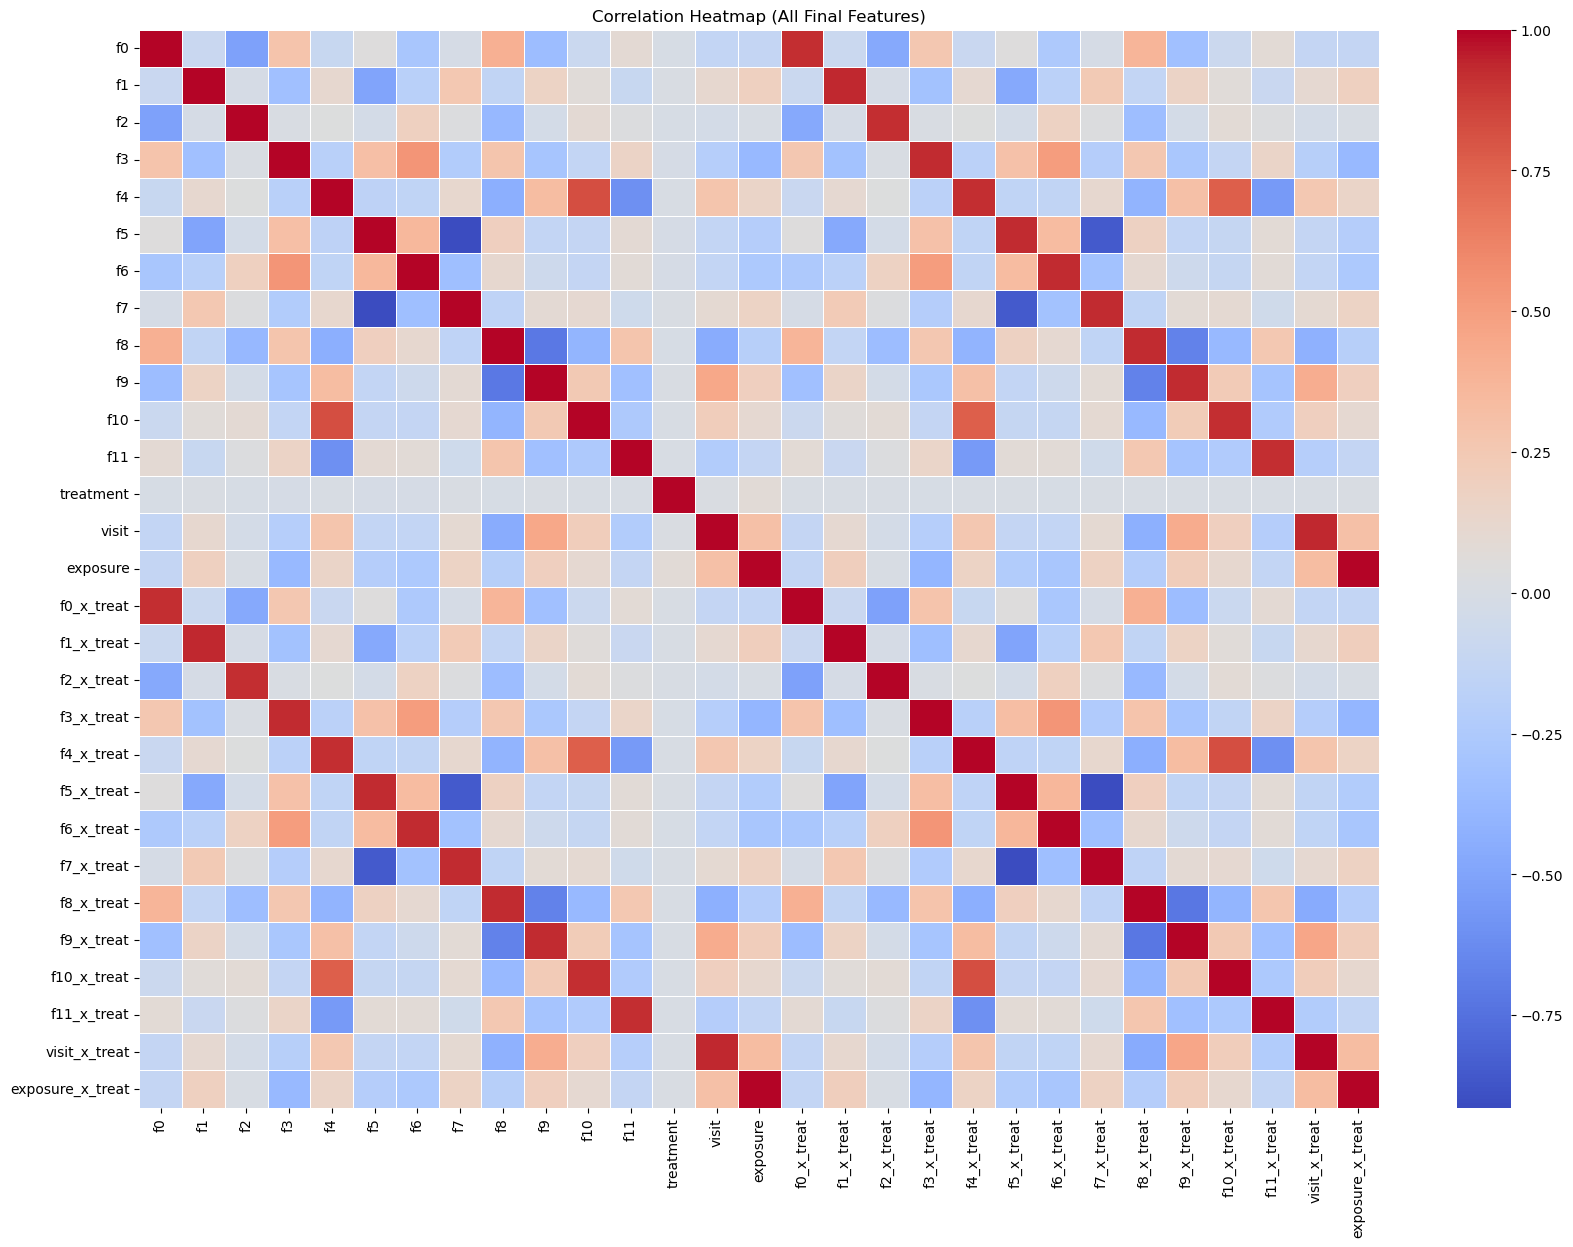

In [45]:

import matplotlib.pyplot as plt
import seaborn as sns
corr = X_train.corr()

plt.figure(figsize=(20, 14))
sns.heatmap(corr, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap (All Final Features)")
plt.show()


## Step 14: Correlation Heatmap — Original Features Only

**Purpose:**  
Examine the correlations among only the **original feature columns** (`f0…f11`), without the interaction features (`*_x_treat`).

**What this code does:**
- Filters out all interaction features.
- Computes correlation on the original features only.
- Plots a clean heatmap to show relationships among the raw signals.

**Why this is important:**
- Interaction features can dominate the heatmap and hide important patterns.
- This view helps identify:
  - highly correlated original features,
  - potential redundancies,
  - any distortions introduced during preprocessing.

Using this, you can better understand the dataset structure before building uplift models.


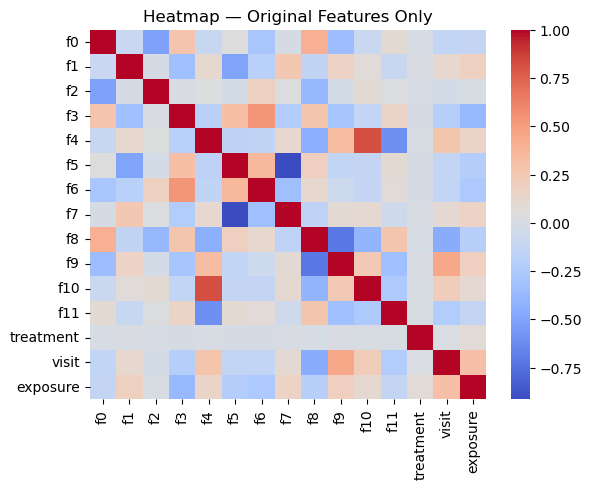

In [46]:
orig_cols = [c for c in X_train.columns if not c.endswith("_x_treat")]
sns.heatmap(X_train[orig_cols].corr(), cmap="coolwarm")
plt.title("Heatmap — Original Features Only")
plt.show()


## Step 15: Compare Feature Correlations — Treated vs Control

**Purpose:**  
Understand how feature relationships differ between:
- users who received treatment (promotion)
- users who did not receive treatment

This is directly connected to uplift modeling because changes in correlation patterns can signal treatment effects.

### What this code does:

1. **Splits** the training data into treated (`train_treat`) and control (`train_ctrl`) groups.
2. **Removes** the `treatment` column from analysis (to avoid trivial correlations).
3. **Computes** separate correlation matrices for treated and control users.
4. **Calculates** the *difference* between these matrices:


In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Separate groups
train_treat = X_train[X_train['treatment'] == 1]
train_ctrl = X_train[X_train['treatment'] == 0]

# Drop treatment itself to avoid trivial correlations
cols = [c for c in X_train.columns if c != 'treatment']

corr_treat = train_treat[cols].corr()
corr_ctrl = train_ctrl[cols].corr()

# Difference
corr_diff = corr_treat - corr_ctrl


## Step 16: Visualize Correlation Differences (Treatment vs Control)

**Purpose:**  
Plot the difference between feature correlations in the treated and control groups to understand how treatment changes user behavior.

**What the heatmap shows:**
- **Red areas** → Feature pairs that become *more correlated* under treatment  
- **Blue areas** → Feature pairs that are *more correlated* in the control group  
- **White areas** → No significant difference

**Why this is useful:**  
Changes in correlation patterns often reveal how treatment influences relationships between features.  
This helps identify which feature interactions might contribute to uplift and where causal effects appear.

The heatmap provides a clear visual summary of these structural differences.


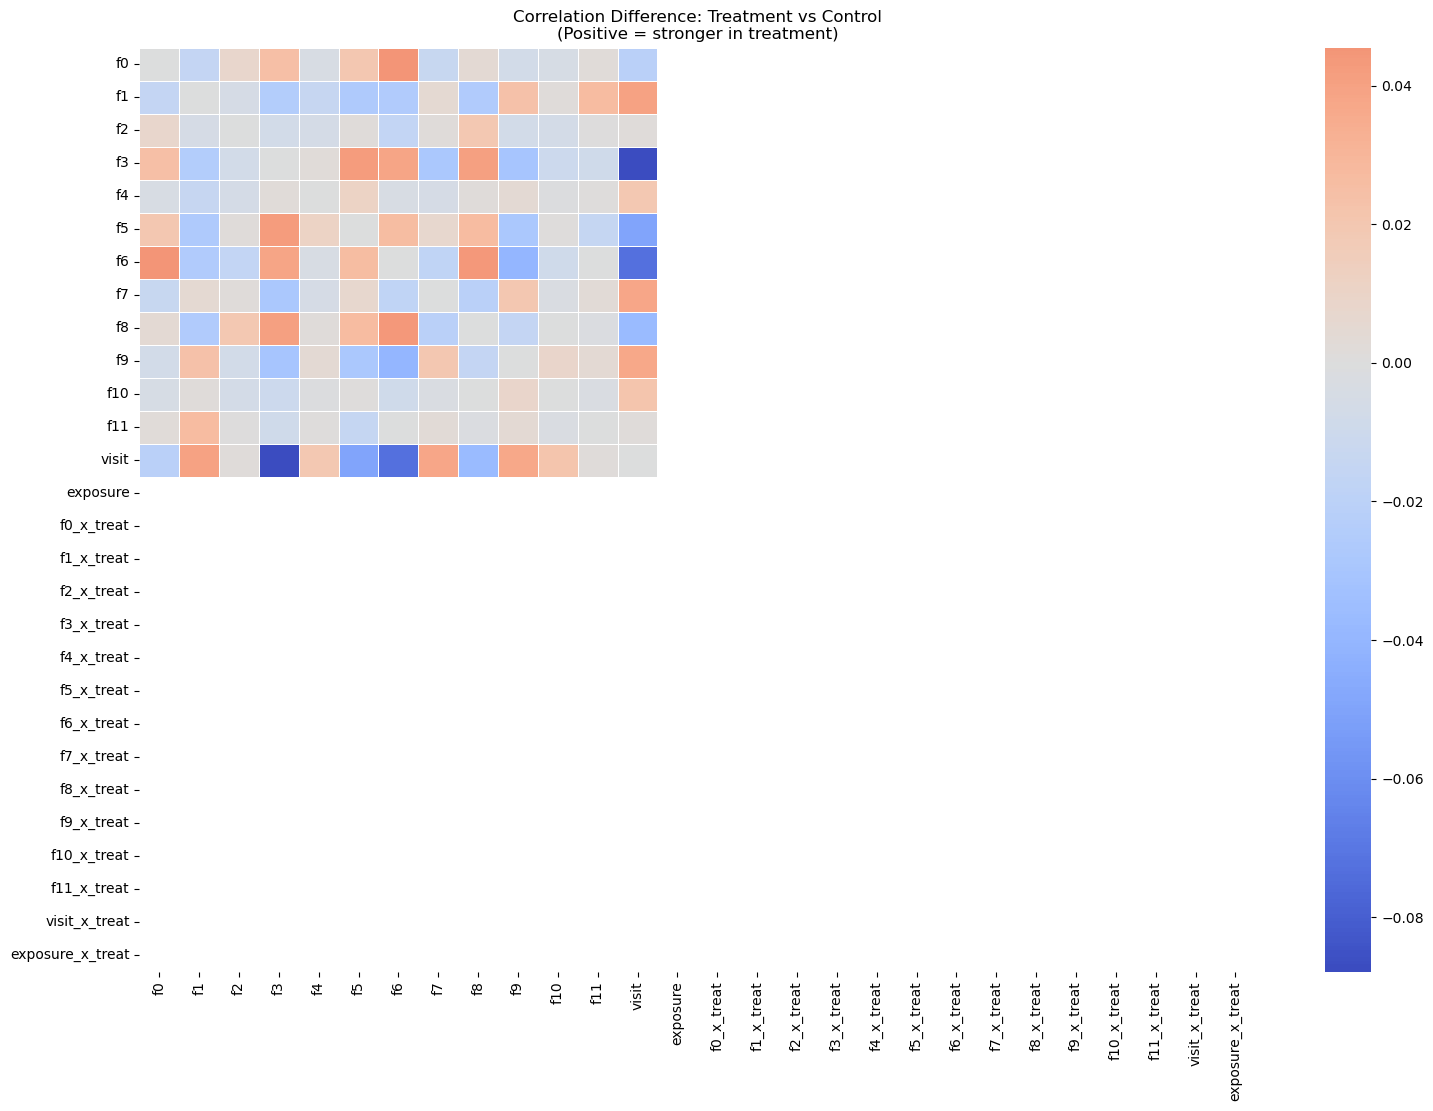

In [48]:
plt.figure(figsize=(18, 12))
sns.heatmap(corr_diff, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Difference: Treatment vs Control\n(Positive = stronger in treatment)")
plt.show()


## Step 17: Feature Importance Analysis — Treated vs Control (Uplift Importance)

**Purpose:**  
Identify which features contribute differently to predictions in the treated and control groups.  
This helps reveal which features drive **uplift** (treatment effect).

### What the code does:

1. **Splits** the training data into:
   - treated users (`treatment = 1`)
   - control users (`treatment = 0`)

2. **Trains two independent Random Forest models:**
   - `model_treat` → predicts outcomes for treated users  
   - `model_ctrl`  → predicts outcomes for control users  

3. **Computes feature importances** for each model.

4. **Calculates uplift importance:**  


In [49]:
from sklearn.ensemble import RandomForestClassifier

# Split into separate treatment/control feature sets
X_treat = X_train[X_train['treatment'] == 1].drop(columns=['treatment'])
y_treat = y_train[X_train['treatment'] == 1]

X_ctrl  = X_train[X_train['treatment'] == 0].drop(columns=['treatment'])
y_ctrl  = y_train[X_train['treatment'] == 0]

# Fit two independent models
model_treat = RandomForestClassifier(
    n_estimators=300, random_state=42
)
model_ctrl = RandomForestClassifier(
    n_estimators=300, random_state=42
)

model_treat.fit(X_treat, y_treat)
model_ctrl.fit(X_ctrl, y_ctrl)

# Get importances
imp_treat = model_treat.feature_importances_
imp_ctrl  = model_ctrl.feature_importances_

# Compute uplift importance
uplift_importance = imp_treat - imp_ctrl

# Pack into DataFrame
import pandas as pd
df_imp = pd.DataFrame({
    "feature": X_treat.columns,
    "importance_treat": imp_treat,
    "importance_ctrl": imp_ctrl,
    "uplift_importance": uplift_importance
}).sort_values("uplift_importance", ascending=False)

df_imp.head(10)


,feature,importance_treat,importance_ctrl,uplift_importance
16,f2_x_treat,0.081989,0.0,0.081989
14,f0_x_treat,0.063201,0.0,0.063201
24,f10_x_treat,0.057546,0.0,0.057546
22,f8_x_treat,0.054201,0.0,0.054201
23,f9_x_treat,0.044865,0.0,0.044865
20,f6_x_treat,0.041256,0.0,0.041256
26,visit_x_treat,0.038947,0.0,0.038947
18,f4_x_treat,0.035190,0.0,0.035190
17,f3_x_treat,0.028871,0.0,0.028871
21,f7_x_treat,0.019486,0.0,0.019486


## Step 18: Visualize Uplift Feature Importance

**Purpose:**  
Plot the uplift importance values (`importance_treat - importance_ctrl`) to see which features behave differently for treated vs control users.

**What the barplot shows:**
- **Positive bars (red)** → feature is more important in the *treated* model  
  → indicates potential to identify users who benefit from treatment  
- **Negative bars (blue)** → feature is more important in the *control* model  
  → may indicate users who don’t need treatment  
- **Near-zero bars** → feature behaves similarly in both groups

**Why this matters:**  
Uplift modeling is all about finding what separates treatment responders from non-responders.  
This visualization reveals which features hold the strongest uplift signal.


C:\Users\raipr\AppData\Local\Temp\ipykernel_35724\1831026857.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


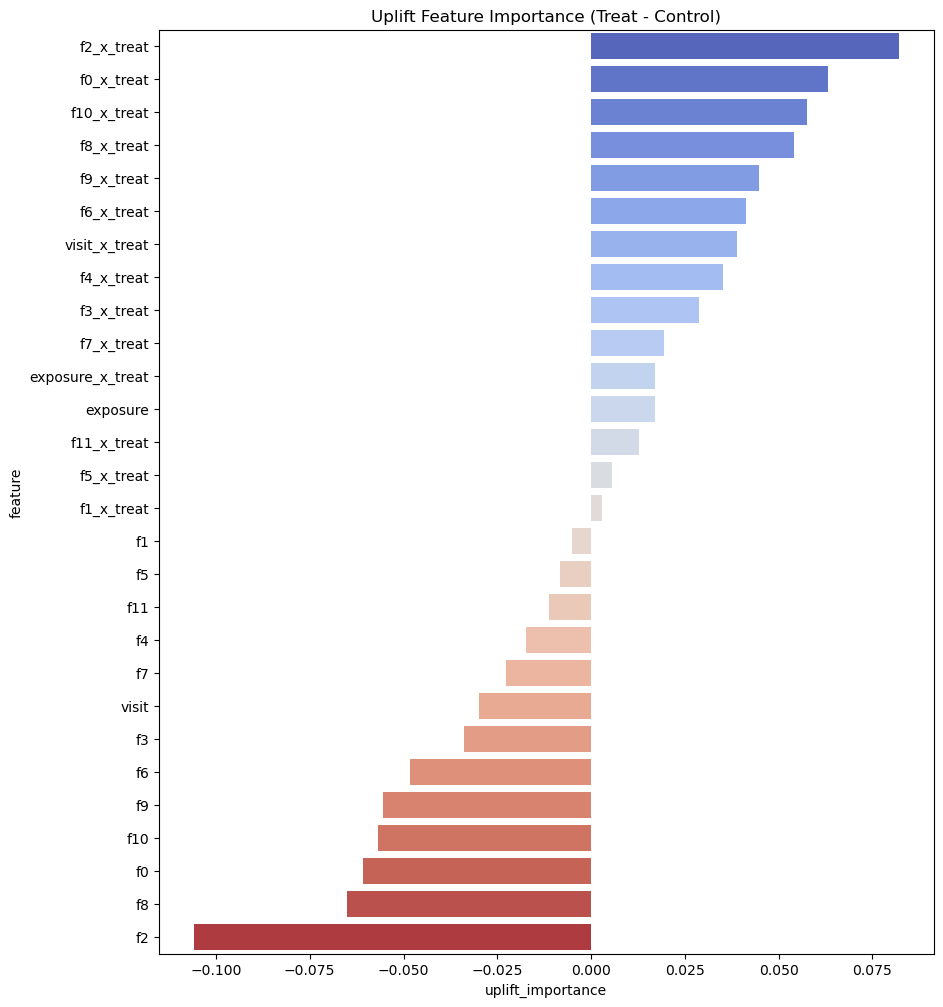

In [50]:
plt.figure(figsize=(10, 12))
sns.barplot(
    data=df_imp.sort_values("uplift_importance", ascending=False),
    x="uplift_importance", y="feature", palette="coolwarm"
)
plt.title("Uplift Feature Importance (Treat - Control)")
plt.show()


## Step 19: Compute Validation Uplift (Two-Model Method)

**Purpose:**  
Estimate the individual uplift for each validation user using the classical two-model approach:
- `model_treat` predicts the probability of outcome **if treated**
- `model_ctrl` predicts the probability of outcome **if not treated**

### What this code does:

1. **Prepare validation features**
   - Keep a copy with the treatment column  
   - Remove `treatment` from the features passed into the models (models should not use it)

2. **Predict `p1`**  
   Probability the user would visit if **given treatment**:



3. **Predict `p0`**  
Probability the user would visit if **not treated**:



4. **Compute uplift**


- Positive → user benefits from promotion  
- Near zero → promotion doesn't change behavior  
- Negative → user may react poorly (rare)

**Why this is important:**  
This gives the validation‐set uplift estimates used to evaluate model performance  
and eventually select customers with uplift > 0 (Easy Problem).


In [51]:
X_val_treat = X_val.copy()  # full features including treatment column
X_val = X_val.drop(columns=['treatment'])

# predict P(Y=1 | T=1, X)
p1 = model_treat.predict_proba(X_val)[:, 1]

# predict P(Y=1 | T=0, X)
p0 = model_ctrl.predict_proba(X_val)[:, 1]

# uplift = difference
uplift_val = p1 - p0


##  Step 20: Qini Curve & Uplift Evaluation Functions

These functions evaluate how good our uplift model is at ranking customers.

###  `compute_qini_curve()`
Builds the Qini uplift curve by:
- sorting users by predicted uplift
- calculating cumulative treated and control outcomes
- computing incremental gain as we target more users

This curve shows how much better our uplift model performs compared to random targeting.

---

###  `compute_auuc()`
Computes **AUUC (Area Under the Uplift Curve)**.
A higher AUUC means better uplift performance.

---

###  `compute_qini_coefficient()`
Computes the **Qini coefficient**, which adjusts for the random baseline.
Interpretation:
- Positive → model is better than random  
- Zero → model = random  
- Negative → model performs worse than random  

---

###  `plot_qini_curve()`
Draws the Qini curve along with the random baseline for visualization.

---

**Why these functions matter:**  
They allow us to objectively judge whether our uplift model truly identifies customers who gain more from treatment — crucial for validating any uplift approach.


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_qini_curve(y_true, treatment, uplift_scores):
    """
    Compute Qini uplift curve.
    """
    df = pd.DataFrame({
        "y": y_true,
        "t": treatment,
        "uplift": uplift_scores
    }).sort_values("uplift", ascending=False)

    df["y_treat"] = df["y"] * df["t"]
    df["y_ctrl"]  = df["y"] * (1 - df["t"])

    df["cum_treat"]   = df["t"].cumsum()
    df["cum_control"] = (1 - df["t"]).cumsum()

    df["cum_y_treat"]   = df["y_treat"].cumsum()
    df["cum_y_control"] = df["y_ctrl"].cumsum()

    # avoid division by zero
    df["qini"] = df["cum_y_treat"] - (
        df["cum_y_control"] * df["cum_treat"] / df["cum_control"].replace(0, np.nan)
    )

    return df["qini"].fillna(0).values


def compute_auuc(qini_curve):
    """
    Area under uplift/Qini curve.
    """
    return np.trapz(qini_curve) / len(qini_curve)


def compute_qini_coefficient(qini_curve):
    """
    Qini coefficient = AUUC - area under random targeting curve.
    """
    n = len(qini_curve)
    random_baseline = np.linspace(0, qini_curve[-1], n)
    area = np.trapz(qini_curve - random_baseline) / n
    return area


def plot_qini_curve(qini_curve):
    """
    Plot Qini / uplift curve.
    """
    plt.figure(figsize=(8,5))
    plt.plot(qini_curve, label="Qini Curve")

    # random baseline
    plt.plot(np.linspace(0, qini_curve[-1], len(qini_curve)),
             linestyle="--", label="Random baseline")

    plt.title("Uplift (Qini) Curve")
    plt.xlabel("Number of samples (sorted by uplift)")
    plt.ylabel("Incremental Gain")
    plt.grid(True)
    plt.legend()
    plt.show()


## Step 21: Evaluate Uplift Model using Qini / AUUC

**Purpose:**  
Evaluate how well the model ranks users by their expected uplift using Qini and AUUC metrics.

**What this block does:**
1. Builds the Qini curve by sorting users by predicted uplift and computing cumulative incremental gain.
2. Computes AUUC (area under the uplift curve): higher means better ranking quality.
3. Computes the Qini coefficient (AUUC adjusted for random baseline): positive values indicate performance better than random.
4. Plots the Qini curve together with the random baseline for visual inspection.

**How to interpret results:**
- `AUUC` (printout): larger → better model ranking.  
- `Qini` (printout): should be **positive**; larger values are better.  
- **Plot**: curve above dashed baseline (especially at left) means the model successfully finds users who benefit most from treatment.

**Notes:** Use these metrics on validation/test sets (never on training) to avoid optimistic estimates.


AUUC: 214.89579301800978
Qini: 137.03718790174523


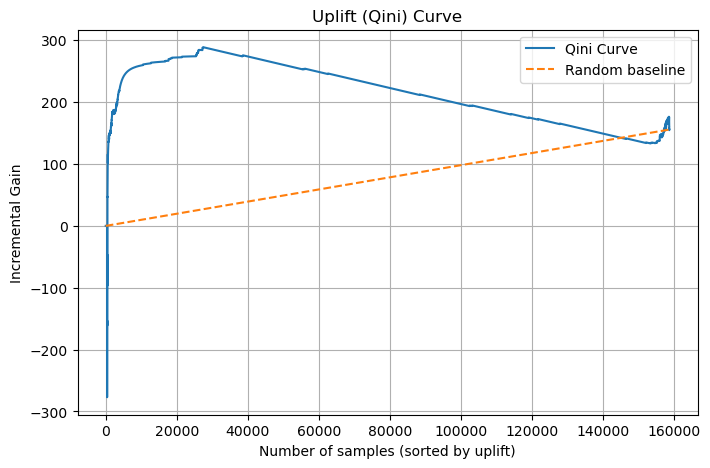

In [53]:
qini_curve = compute_qini_curve(
    y_true = y_val.values,
    treatment = X_val_treat['treatment'].values,
    uplift_scores = uplift_val
)

print("AUUC:", compute_auuc(qini_curve))
print("Qini:", compute_qini_coefficient(qini_curve))

plot_qini_curve(qini_curve)
